In [5]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import glob
import os, sys, json 

from dateutil.relativedelta import relativedelta
import datetime as dt
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#os.getcwd()
#set(df_data['stream_id'].unique()) - set(pro_df_data['stream_id'].unique())
#set(pro_df_data['stream_id'].unique()) - set(df_data['stream_id'].unique())
#date=dff.apply(lambda x: datetime.date(int(x['year']), x['month'], x['day']),axis=1)
#df_day["country"] = df_day['country'].astype('category').cat.codes

# Part 1

In [6]:
## Load data
def get_file_list(json_dir_name):
    json_pattern = os.path.join(json_dir_name, '*.json')
    file_list = glob.glob(json_pattern)
    return(file_list)

def load_data(file_list):
    df = []
    for file in file_list:
        with open(file) as rfile:
            data = pd.read_json (rfile)
            df.append(data)
    dff = pd.DataFrame( np.concatenate(df, axis=0 ) )
    dff.columns = df[0].columns
    return(dff)


## Clean
def clean_df(df_data):
    df_data['date'] = pd.to_datetime(df_data[['year', 'month', 'day']])
    df_data = df_data.drop(['invoice','stream_id','customer_id'], axis=1) 
    #print(df_data.describe())
    df_gb = df_data.groupby(['country','date']).agg({'price': 'sum', 'times_viewed': 'sum'}).reset_index()
    return(df_gb)


## Features 
def feature_df(df_clean):
    df_day = df_clean.set_index('date').groupby('country').resample("1D").sum().reset_index() # 18094 rows × 4 columns
    #print(df_day.describe())
    for i in [2, 7, 15, 30, 90, 365]: # with revenue for the previous day, previous week, previous month and previous three months
        df_price = df_day.groupby('country')['price'].rolling(window=i).sum().fillna(method='bfill').to_frame().reset_index()
        df_viewed = df_day.groupby('country')['times_viewed'].rolling(window=i).sum().fillna(method='bfill').to_frame().reset_index()
        df_day['price_%dD'%i]= df_price[['price']]
        df_day['viewed_%dD'%i]= df_viewed[['times_viewed']]
    df_day['year'] = df_day['date'].dt.year
    df_day['month'] = df_day['date'].dt.month
    df_day['day'] = df_day['date'].dt.day
    return(df_day) 

In [7]:
json_dir_name = 'cs-train'
file_list = get_file_list(json_dir_name)

df_data = load_data(file_list) # 815011 rows × 9 columns
df_clean = clean_df(df_data) # 2534 rows × 2 columns
df_day = feature_df(df_clean) # 18094

## EDA - monthly

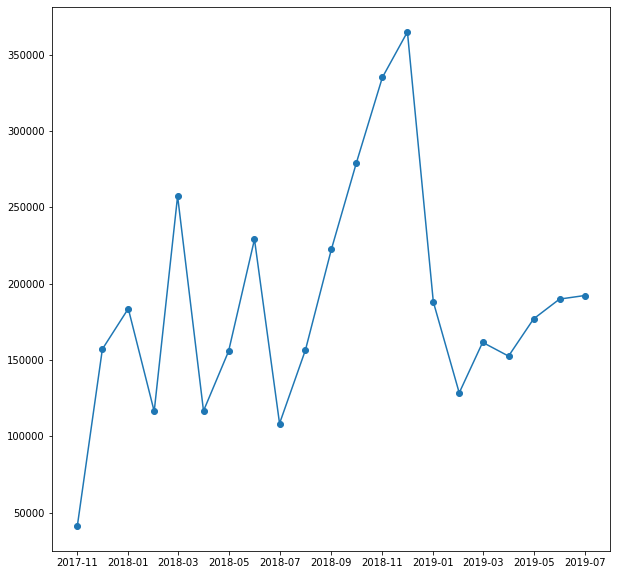

In [8]:
df_eda = df_day.groupby(['year','month']).agg({'price': 'sum', 'times_viewed': 'sum'}).reset_index()
df_eda['date'] = pd.to_datetime([f'{y}-{m}-01' for y, m in zip(df_eda.year, df_eda.month)])

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(df_eda['date'], df_eda['price'], marker='o', linestyle='-')

# Part 2 
## Basic line model

In [9]:
cat_encoder = LabelEncoder()

df_day['country_cd'] = cat_encoder.fit_transform(df_day['country'])
df_day = df_day.drop(['date','country','year','month','day','times_viewed'], axis=1) 

df_day = df_day.fillna(0)
X = df_day.copy().drop('price', axis=1)
Y = df_day['price']

In [12]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

In [ ]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, Y)

# Part 3 - Production test

In [99]:
pro_json_dir_name = 'cs-production'

pro_file_list = get_file_list(pro_json_dir_name)
pro_df_data = load_data(pro_file_list) # 252359 rows × 9 columns
pro_df_clean = clean_df(pro_df_data)   # 703 rows × 4 columns

               country      price  times_viewed                 date
count           252359  252359.00      252359.0               252359
unique              32     722.00          25.0                  109
top     United Kingdom       1.25           1.0  2019-12-02 00:00:00
freq            230102   24454.00       68390.0                 5331
first              NaN        NaN           NaN  2019-08-01 00:00:00
last               NaN        NaN           NaN  2019-12-06 00:00:00
